# Youtube analysis
This notebook plans on creating an initial approach to the google's youtube api. Looking for interesting endpoints.

In [67]:
from dotenv import load_dotenv
import os
from googleapiclient.discovery import build
from IPython.display import JSON
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns

In [7]:
load_dotenv()

api_service_name = "youtube"
api_version = "v3"
API_KEY = os.getenv('API_KEY')

In [8]:
# API_client
youtube = build(
    api_service_name, api_version, developerKey=API_KEY)




In [31]:
request = youtube.channels().list(
    part = "snippet, contentDetails, statistics",
    id = 'UCZNTsLA6t6bRoj-5QRmqt_w'
)
response = request.execute()

In [32]:
response

{'kind': 'youtube#channelListResponse',
 'etag': 'DYN9DHPd7qlS0KLxNM1TX5kK2uU',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': '16gvnl9KtxjY_LXwxZpYrUo9Ews',
   'id': 'UCZNTsLA6t6bRoj-5QRmqt_w',
   'snippet': {'title': 'LowkoTV',
    'description': 'New videos Monday-Saturday. Mostly StarCraft 2, but also other games from time to time. Thanks for watching!',
    'customUrl': '@lowkotv',
    'publishedAt': '2008-02-11T14:09:44Z',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/ENP4AxSVuAvG-tqWoJmXhOs4Ix28PX8JYdeM7Pejbq6ufiXDUxMie6fLsozrkWWT3Oe2O8r9Dw8=s88-c-k-c0x00ffffff-no-rj',
      'width': 88,
      'height': 88},
     'medium': {'url': 'https://yt3.ggpht.com/ENP4AxSVuAvG-tqWoJmXhOs4Ix28PX8JYdeM7Pejbq6ufiXDUxMie6fLsozrkWWT3Oe2O8r9Dw8=s240-c-k-c0x00ffffff-no-rj',
      'width': 240,
      'height': 240},
     'high': {'url': 'https://yt3.ggpht.com/ENP4AxSVuAvG-tqWoJmXhOs4Ix28PX8JYdeM7Pejbq6ufiXDUxMie6fLsozrkWWT3Oe

In [52]:
def get_channel_info(api_builder, channel_ids):
    """
    :param api_builder: google api_builder class initialized 
    :param channel_ids: list of ids of channels 
    :return: pd.DataFrame with stats about the channel
    """
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_ids
    )
    response = request.execute()
    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)


In [53]:
channel_id = 'UCZNTsLA6t6bRoj-5QRmqt_w' # Lowko's
lowko_try = get_channel_info(youtube, channel_id)

In [54]:
lowko_try

,channelName,subscribers,views,totalVideos,playlistId
0,LowkoTV,521000,320484871,4211,UUZNTsLA6t6bRoj-5QRmqt_w


In [55]:
def get_video_ids(api_builder, playlist_id):
    
    video_ids = []
    
    request = api_builder.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = api_builder.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(api_builder, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = api_builder.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [56]:
playlist_id = 'UUZNTsLA6t6bRoj-5QRmqt_w'
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

4211

In [57]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,57NUag1kW00,LowkoTV,Solar gets TERRAN RUSHED REPEATEDLY by ByuN! (...,Best-of-5 series that's the StarCraft 2 finals...,"[Lowko, LowkoTV, Simon Heijnen, Tutorial, Guid...",2024-01-27T15:00:03Z,40337,1299,None,55,PT36M10S,hd,false
1,sA_qTwYqCpw,LowkoTV,Rank #1 Protoss gives Lowko a Shout-out! (Star...,Best shout-out I've ever had! Thanks MaxPax!\n...,"[Lowko, LowkoTV, Simon Heijnen, Tutorial, Guid...",2024-01-27T10:09:35Z,15909,988,None,28,PT54S,hd,false
2,0HgIa8nhFHI,LowkoTV,ByuN CALLS herO's BLUFF! (StarCraft 2),Best-of-3 series of StarCraft 2 between herO (...,"[Lowko, LowkoTV, Simon Heijnen, Tutorial, Guid...",2024-01-26T15:00:00Z,35210,1432,None,48,PT27M51S,hd,false
3,lfbMocO4z_M,LowkoTV,NO WAY! herO's Mothership Recall GOES WRONG! (...,Best-of-5 series of top level StarCraft 2 betw...,"[Lowko, LowkoTV, Simon Heijnen, Tutorial, Guid...",2024-01-25T15:00:43Z,39112,1180,None,108,PT1H16M59S,hd,false
4,JFrElthRViM,LowkoTV,StarCraft 2: MaxPax plays EVEN FASTER than Clem?!,Best-of-5 series of top level StarCraft 2 betw...,"[Lowko, LowkoTV, Simon Heijnen, Tutorial, Guid...",2024-01-24T15:00:17Z,59825,3017,None,264,PT48M32S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,UhCQe-Aq2Vw,LowkoTV,"★ Starcraft 2 FPVOD First Person Live Game: ""Z...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,"[starcraft 2, starcraft, star, craft, star cra...",2011-09-30T13:28:15Z,3181,34,None,13,PT8M2S,hd,false
4207,9-I0PR7MEdA,LowkoTV,"Starcraft II Study #3 - ""My Heart For The Swar...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,"[starcraft 2, starcraft, star, craft, star cra...",2011-09-27T16:45:18Z,5063,44,None,13,PT5M13S,hd,false
4208,1H97lbBR4Mg,LowkoTV,"★ Starcraft 2 Master: ""Multiplayer 1v1 Analysi...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,"[starcraft 2, starcraft, star, craft, star cra...",2011-09-23T02:14:23Z,4234,38,None,7,PT7M11S,hd,false
4209,pgsjXhfAbLw,LowkoTV,"Starcraft II Study #2 - ""My Heart For The Swar...",More LowkoTV\n▶ Subscribe | http://www.lowkotv...,"[starcraft 2, starcraft, star, craft, star cra...",2011-09-22T05:57:47Z,6227,87,None,22,PT2M19S,hd,false


In [58]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [59]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [60]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [63]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [64]:
# Duration 
video_df[['durationSecs', 'duration']] 


,durationSecs,duration
0,0 days 00:36:10,PT36M10S
1,0 days 00:00:54,PT54S
2,0 days 00:27:51,PT27M51S
3,0 days 01:16:59,PT1H16M59S
4,0 days 00:48:32,PT48M32S
...,...,...
4206,0 days 00:08:02,PT8M2S
4207,0 days 00:05:13,PT5M13S
4208,0 days 00:07:11,PT7M11S
4209,0 days 00:02:19,PT2M19S


In [65]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

C:\Users\omara\AppData\Local\Temp\ipykernel_23220\220866667.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


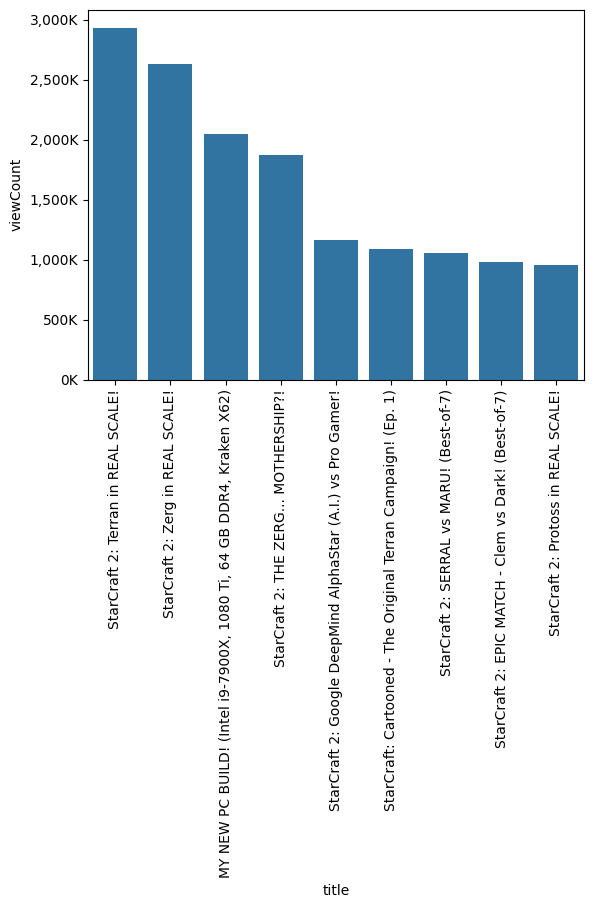

In [68]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

C:\Users\omara\AppData\Local\Temp\ipykernel_23220\2753171122.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


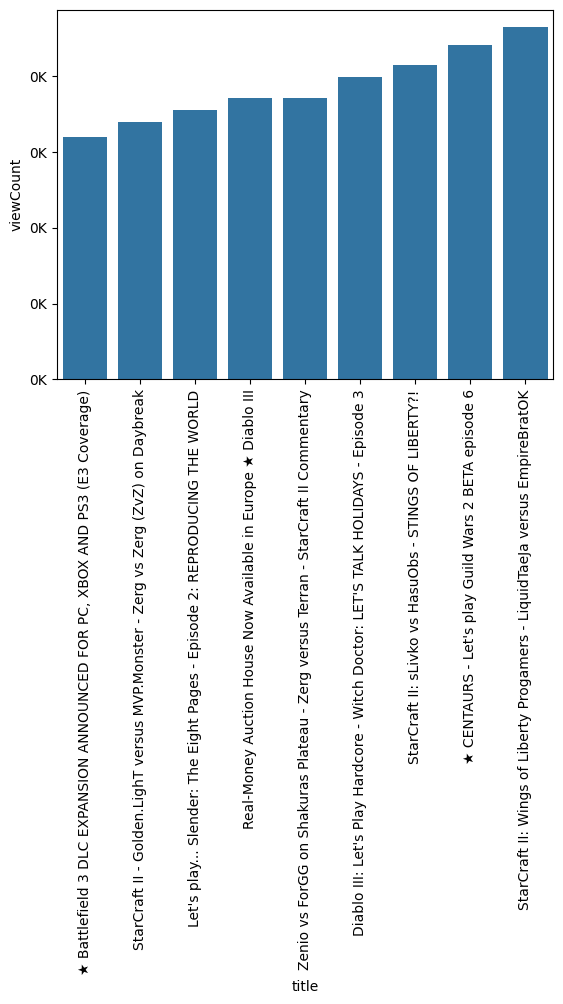

In [69]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<Axes: xlabel='channelTitle', ylabel='viewCount'>

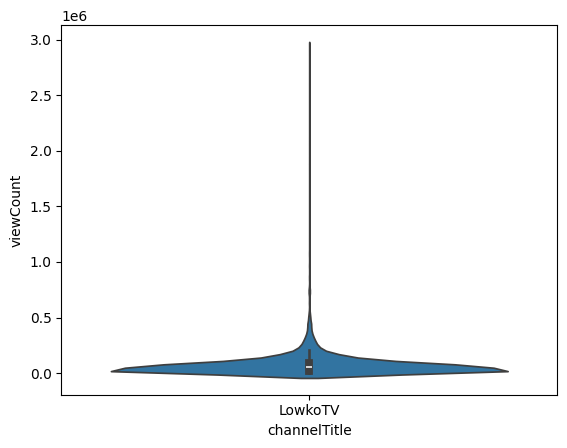

In [74]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

<Axes: xlabel='likeCount', ylabel='viewCount'>

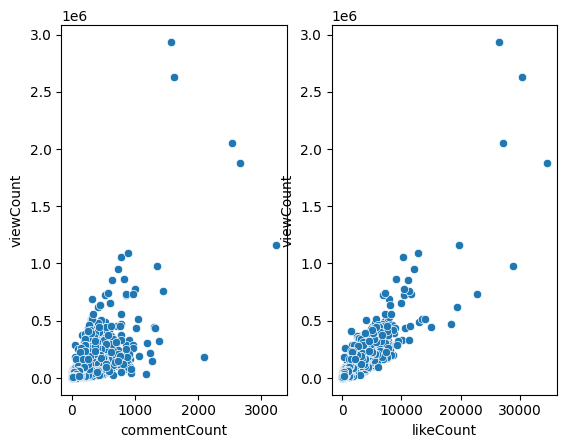

In [76]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<Axes: xlabel='durationSecs', ylabel='Count'>

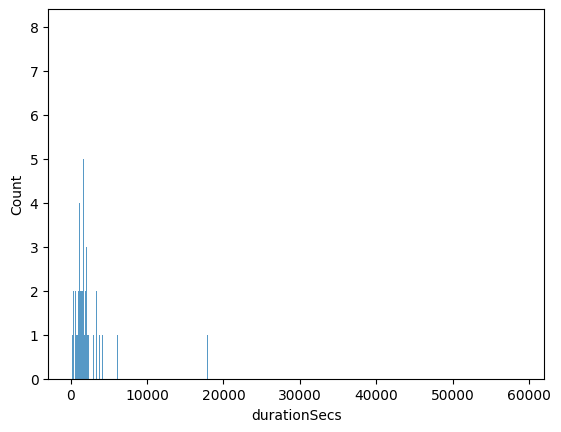

In [77]:
# Video duration
sns.histplot(data = video_df, x = 'durationSecs', bins=30)


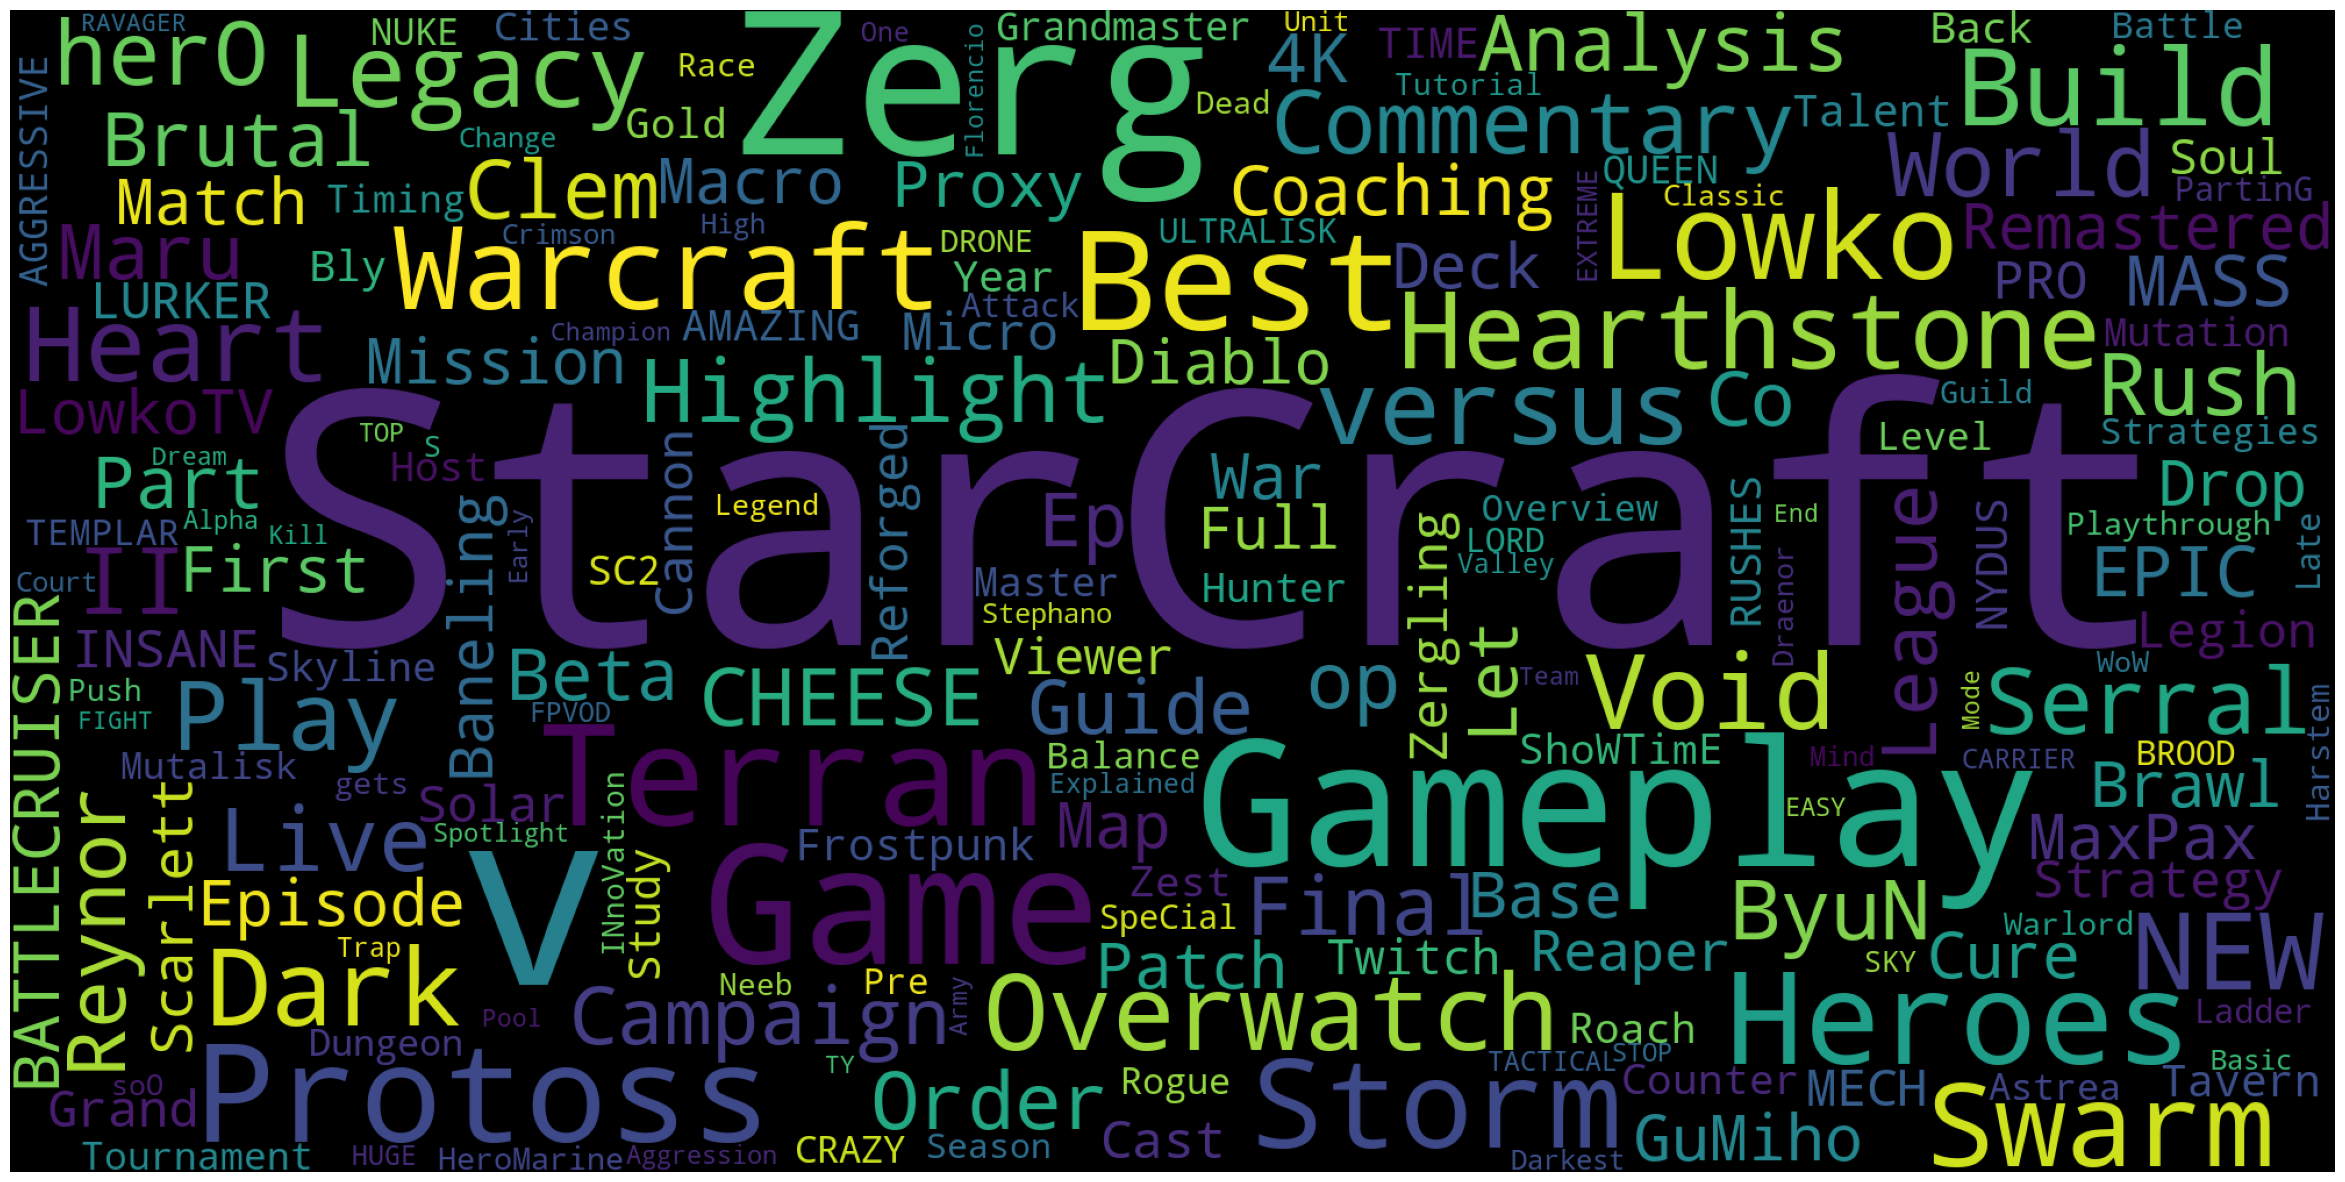

In [78]:
# Video titles wordcloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)